In [ ]:
!pip install torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
IMAGE_DIM = (32, 32, 3)
from model import Discriminator, Generator
from dataloader import POKE

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
!unzip -q "drive/My Drive/ZIP_FILES/PokemonImg.zip" -d "Dataset2" | head -n 5

# Unwanted Images(Grayscale Images)

In [ ]:
from PIL import Image
import os

def is_grayscale(image_path):
    img = Image.open(image_path)
    return img.mode == 'L'  # 'L' indicates grayscale mode in PIL

def is_4d(image_path):
    img = Image.open(image_path)
    return len(img.getbands()) == 4  # Check if the image has 4 channels

# Replace 'your_dataset_folder' with the path to your dataset folder
dataset_folder = 'Dataset2'
unwanted_images = []

for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        image_path = os.path.join(root, file)
        if is_grayscale(image_path) or is_4d(image_path):
            unwanted_images.append(image_path)

print(f"Number of unwanted images: {len(unwanted_images)}")
print(unwanted_images)


Number of unwanted images: 549
['Dataset2/PokemonImg/9a74519575c540d3963296a36bbd25d7.jpg', 'Dataset2/PokemonImg/91fab894d10b4a33b1bdf7c9f7990137.jpg', 'Dataset2/PokemonImg/610e57345d9c48bebb6afe7c5bdaef20.jpg', 'Dataset2/PokemonImg/00000237.png', 'Dataset2/PokemonImg/bb7a1ff8f3c3472b9cb0f5c1d48fa650.jpg', 'Dataset2/PokemonImg/00000121.png', 'Dataset2/PokemonImg/21dd24c7a7754d0188cab0ea595c7c89.jpg', 'Dataset2/PokemonImg/ba6dfaf01d2449e7a6047230e5958249.jpg', 'Dataset2/PokemonImg/482fea09f70f47a79a6885e2a654a426.jpg', 'Dataset2/PokemonImg/c59e2bc85b1840bea2d74c6b770612a3.jpg', 'Dataset2/PokemonImg/00000174.png', 'Dataset2/PokemonImg/1997556785c144dbb79f8caacdf9883c.jpg', 'Dataset2/PokemonImg/09c63b017432480d9c9d63ed44f4c9df.jpg', 'Dataset2/PokemonImg/e23ff8044efa47f1a7d636dd9474bc4f.jpg', 'Dataset2/PokemonImg/99149b4e20114cf18e031fabdb2b8c0e.jpg', 'Dataset2/PokemonImg/d7ac514ad0ef4fb9999e8901a69e444c.jpg', 'Dataset2/PokemonImg/2a06cdb2d8104cddb7b056e24b3b523e.jpg', 'Dataset2/PokemonImg

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)

In [ ]:
from PIL import Image

def convert_palette_to_rgba(image):
    if image.mode == 'P':
        return image.convert('RGBA')
    return image


transform = transforms.Compose([
    #transforms.Lambda(convert_palette_to_rgba),  # Convert palette images to RGBA
    transforms.Resize((IMAGE_DIM[0], IMAGE_DIM[1])),
    #transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])



In [ ]:
dataset = POKE(data_path='Dataset2/PokemonImg',transform=transform,grayscale_images=unwanted_images)

In [ ]:
len(dataset)
remaining_grayscale_images = []
for idx in range(len(dataset)):
    img_path = dataset.fpaths[idx]
    if is_grayscale(img_path):
        remaining_grayscale_images.append(img_path)



In [ ]:
len(remaining_grayscale_images)

0

In [ ]:
batch_size = 64

# Ensuring consistent Image dimensions in all batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
# Define your collate_fn function
def collate_fn(batch):
    max_height = max([img.shape[1] for img in batch])
    max_width = max([img.shape[2] for img in batch])

    padded_images = []
    for img in batch:
        c, h, w = img.shape
        padded_img = torch.zeros(3, max_height, max_width)
        padded_img[:, :h, :w] = img
        padded_images.append(padded_img)

    return torch.stack(padded_images)



In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8, collate_fn=collate_fn)


In [ ]:
for batch_idx, batch in enumerate(data_loader):
    print(f"Batch Index: {batch_idx}")
    print(f"Batch Shape: {batch.shape}")  # Check the shape of the batch


Batch Index: 0
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 1
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 2
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 3
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 4
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 5
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 6
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 7
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 8
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 9
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 10
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 11
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 12
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 13
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 14
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 15
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 16
Batch Shape: torch.Size([64, 3, 32, 32])
Batch Index: 17
Batch Shape: torch.Size([

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

# Model Training

In [ ]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            # create folder by right clicking in the file window and name the folder 'samples'
            #imsave('content/samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.3977, G Loss: 0.7229, Time:15:19:54
Epoch: 3/100, Step: 500, D Loss: 1.2309, G Loss: 1.1277, Time:15:20:42
Epoch: 6/100, Step: 1000, D Loss: 1.3432, G Loss: 1.4835, Time:15:21:29
Epoch: 10/100, Step: 1500, D Loss: 0.9868, G Loss: 1.2848, Time:15:22:17
Epoch: 13/100, Step: 2000, D Loss: 0.8722, G Loss: 1.8350, Time:15:23:05
Epoch: 17/100, Step: 2500, D Loss: 1.6693, G Loss: 3.0757, Time:15:23:53
Epoch: 20/100, Step: 3000, D Loss: 0.7738, G Loss: 1.4078, Time:15:24:41
Epoch: 23/100, Step: 3500, D Loss: 0.6457, G Loss: 2.6568, Time:15:25:28
Epoch: 27/100, Step: 4000, D Loss: 0.7653, G Loss: 3.5519, Time:15:26:17
Epoch: 30/100, Step: 4500, D Loss: 0.7627, G Loss: 1.9473, Time:15:27:04
Epoch: 34/100, Step: 5000, D Loss: 0.7835, G Loss: 2.1899, Time:15:27:51
Epoch: 37/100, Step: 5500, D Loss: 0.3354, G Loss: 1.9604, Time:15:28:38
Epoch: 41/100, Step: 6000, D Loss: 1.0873, G Loss: 3.4764, Time:15:29:25
Epoch: 44/100, Step: 6500, D Loss: 0.5611, G Loss: 5.4933,

# Results

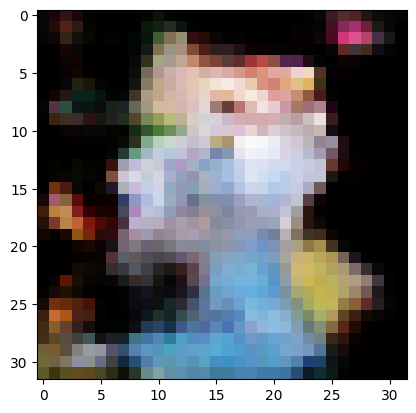

In [ ]:
G.eval()#Generated Image sample
imshow(get_sample_image(G, n_noise)[0])

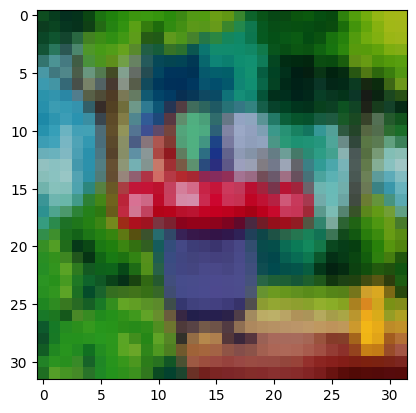

In [ ]:
t = Image.open(dataset.fpaths[31])#Actual Pokemon image sample
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [ ]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)